### Student Information

Name: **黃星翰**

Student ID: **112062627**

GitHub ID: **FrHTate**

Kaggle name: **Sakun**

Kaggle private scoreboard snapshot:

![pic0](img/pic0.png)


---


### Instructions


1. First: **This part is worth 30% of your grade.** Do the **take home exercises** in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook.

2. Second: **This part is worth 30% of your grade.** Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking:

   - **Bottom 40%**: Get 20% of the 30% available for this section.

   - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) _ 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 _ 100 + 1 - 3) / (0.6 _ 100) _ 10 + 20 = 29.67% out of 30%.)  
     Submit your last submission **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.

3. Third: **This part is worth 30% of your grade.** A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained.

4. Fourth: **This part is worth 10% of your grade.** It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.

Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**.


In [ ]:
### Begin Assignment Here

# Load all needed libraries in this homework
import os
import json
import re

import numpy as np
import pandas as pd
import nltk
from sklearn import preprocessing
import transformers as T
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

# Set the style I'm going to use for plotting
sns.set_style("dark")
sns.set_palette("pastel")

# Define the path to the data files
CURRENT_PATH = os.path.abspath("")
DATA_FILE_PATH = os.path.join(CURRENT_PATH, "data")
RAW_DATA_PATH = os.path.join(DATA_FILE_PATH, "tweets_DM.json")
LABEL_PATH = os.path.join(DATA_FILE_PATH, "emotion.csv")
DATA_PARTITION_PATH = os.path.join(DATA_FILE_PATH, "data_identification.csv")

# Config related to my model
device = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "FacebookAI/roberta-base"
lr = 3e-5
batch_size = 96
drop_out = 0.2
epochs = 5
weight_decay = 1e-2

# 1. Data Preparation


In [ ]:
# Open the data files
with open(RAW_DATA_PATH) as f:
    raw_data = pd.read_json(f, lines=True)

with open(LABEL_PATH) as f:
    label = pd.read_csv(f)

with open(DATA_PARTITION_PATH) as f:
    data_partition = pd.read_csv(f)

In [3]:
# Check how the given data looks like
print("Raw data shape: ", raw_data.shape)
print("Label shape: ", label.shape)
print("Data partition shape: ", data_partition.shape)
print()

print("Raw data overview: ")
display(raw_data.head())

print("Label overview: ")
display(label.head())

print("Data partition overview: ")
display(data_partition.head())

Raw data shape:  (1867535, 5)
Label shape:  (1455563, 2)
Data partition shape:  (1867535, 2)

Raw data overview: 


,_score,_index,_source,_crawldate,_type
0,391,hashtag_tweets,"{'tweet': {'hashtags': ['Snapchat'], 'tweet_id...",2015-05-23 11:42:47,tweets
1,433,hashtag_tweets,"{'tweet': {'hashtags': ['freepress', 'TrumpLeg...",2016-01-28 04:52:09,tweets
2,232,hashtag_tweets,"{'tweet': {'hashtags': ['bibleverse'], 'tweet_...",2017-12-25 04:39:20,tweets
3,376,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x1cd5...",2016-01-24 23:53:05,tweets
4,989,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x2de2...",2016-01-08 17:18:59,tweets


Label overview: 


,tweet_id,emotion
0,0x3140b1,sadness
1,0x368b73,disgust
2,0x296183,anticipation
3,0x2bd6e1,joy
4,0x2ee1dd,anticipation


Data partition overview: 


,tweet_id,identification
0,0x28cc61,test
1,0x29e452,train
2,0x2b3819,train
3,0x2db41f,test
4,0x2a2acc,train


In [4]:
# Check how raw_data['_source'] looks like
print("Data type of raw_data['_source']: ", type(raw_data["_source"][0]))
print()

print("Content in raw_data['_source']: ")
print(raw_data["_source"][0])

Data type of raw_data['_source']:  <class 'dict'>

Content in raw_data['_source']: 
{'tweet': {'hashtags': ['Snapchat'], 'tweet_id': '0x376b20', 'text': 'People who post "add me on #Snapchat" must be dehydrated. Cuz man.... that\'s <LH>'}}


# 2. EDA


## 2.1 Feature Subset Selection

Since all the data in attributes like '\_index', '\_source', '\_hashtags' are all the same, so there is no helpful information for me to do classification. Hence, I decide to delete these attributes.


In [5]:
# Feature subset selection
# 1. Extract the information in raw_data['_source'] and append it to raw_data.
raw_data["_tweet_id"] = raw_data["_source"].apply(lambda x: x["tweet"]["tweet_id"])
raw_data["_text"] = raw_data["_source"].apply(lambda x: x["tweet"]["text"])
raw_data["_hashtags"] = raw_data["_source"].apply(lambda x: x["tweet"]["hashtags"])

# 2. Check whether some information in raw_data is identical, if so, then the information is redundant.
print(
    f"The amount of raw_data['_index'] != 'hashtag_tweets' is: "
    f"{raw_data['_index'].apply(lambda x: x != 'hashtag_tweets').sum()}"
)
print(
    f"The amount of raw_data['_source'].keys() != ['tweet'] is: "
    f"{raw_data['_source'].apply(lambda x: list(x) != ['tweet']).sum()}"
)
print(
    f"The amount of raw_data['_type'] != 'tweets' is: "
    f"{raw_data['_type'].apply(lambda x: x != 'tweets').sum()}"
)

# 3. Drop the redundant columns.
raw_data.drop(columns=["_index", "_source", "_type"], inplace=True)

The amount of raw_data['_index'] != 'hashtag_tweets' is: 0
The amount of raw_data['_source'].keys() != ['tweet'] is: 0
The amount of raw_data['_type'] != 'tweets' is: 0


In [6]:
# Check how raw_data looks like after data feature subset selection
display(raw_data.head())

,_score,_crawldate,_tweet_id,_text,_hashtags
0,391,2015-05-23 11:42:47,0x376b20,"People who post ""add me on #Snapchat"" must be ...",[Snapchat]
1,433,2016-01-28 04:52:09,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...","[freepress, TrumpLegacy, CNN]"
2,232,2017-12-25 04:39:20,0x28b412,"Confident of your obedience, I write to you, k...",[bibleverse]
3,376,2016-01-24 23:53:05,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,[]
4,989,2016-01-08 17:18:59,0x2de201,"""Trust is not the same as faith. A friend is s...",[]


## 2.2 Data Cleaning

1. Check how many duplicated texts, but some of them might be an onject of testing dataset, so I will remove them later.
2. Check how many empty texts, if there are any empty text, then it should be removed. (Since it won't provide any value for training.)
3. Check how many empty hashtags to help me decide how to utilize it.
4. Rename the data to have a better formmat for me to use.


In [7]:
# Check whether there are missing values or duplicated values in raw_data
print(f"The amount of missing value is:\n{raw_data.isnull().apply(sum)}\n")
print(
    "The amount of duplicated text is: " f"{raw_data[['_text']].duplicated().sum()}"
)  # The duplicated text will be removed after splitting the dataset (only delete for training set)

The amount of missing value is:
_score        0
_crawldate    0
_tweet_id     0
_text         0
_hashtags     0
dtype: int64

The amount of duplicated text is: 3920


In [8]:
# Check how many object has empty '_text'
print(
    f"The amount of empty '_text' is: "
    f"{raw_data['_text'].apply(lambda x: x == '').sum()}"
)

# Check how many object has empty '_hashtags'
print(
    f"The amount of empty '_hashtags' is: "
    f"{raw_data['_hashtags'].apply(lambda x: x == []).sum()}"
)

# Since the amount of empty '_hashtags' is about 51.66%,
# but this attribute is very useful for me to do classification,
# so I decide to keep this attribute and fill the empty '_hashtags' with NaN.
raw_data["_hashtags"] = raw_data["_hashtags"].apply(lambda x: np.nan if x == [] else x)

The amount of empty '_text' is: 0
The amount of empty '_hashtags' is: 964713


In [9]:
# Rename the attribute name of raw_data
raw_data.rename(columns={"_score": "score"}, inplace=True)
raw_data.rename(columns={"_crawldate": "crawldate"}, inplace=True)
raw_data.rename(columns={"_tweet_id": "tweet_id"}, inplace=True)
raw_data.rename(columns={"_text": "text"}, inplace=True)
raw_data.rename(columns={"_hashtags": "hashtags"}, inplace=True)

In [10]:
display(raw_data.head())

,score,crawldate,tweet_id,text,hashtags
0,391,2015-05-23 11:42:47,0x376b20,"People who post ""add me on #Snapchat"" must be ...",[Snapchat]
1,433,2016-01-28 04:52:09,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...","[freepress, TrumpLegacy, CNN]"
2,232,2017-12-25 04:39:20,0x28b412,"Confident of your obedience, I write to you, k...",[bibleverse]
3,376,2016-01-24 23:53:05,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,NaN
4,989,2016-01-08 17:18:59,0x2de201,"""Trust is not the same as faith. A friend is s...",NaN


## 2.3 Split Dataset


In [11]:
raw_data = raw_data.merge(
    data_partition, left_on="tweet_id", right_on="tweet_id", how="inner"
)

training_data = (
    raw_data[raw_data["identification"] == "train"]
    .drop(columns=["identification"])
    .reset_index(drop=True)
)
testing_data = (
    raw_data[raw_data["identification"] == "test"]
    .drop(columns=["identification"])
    .reset_index(drop=True)
)

In [12]:
# Check the shape of training_data and testing_data
print("Training data shape: ", training_data.shape)
print("Testing data shape: ", testing_data.shape)

# Check the overview of training_data and testing_data
print("Training data overview:")
display(training_data.head())

print("Testing data overview:")
display(testing_data.head())

Training data shape:  (1455563, 5)
Testing data shape:  (411972, 5)
Training data overview:


,score,crawldate,tweet_id,text,hashtags
0,391,2015-05-23 11:42:47,0x376b20,"People who post ""add me on #Snapchat"" must be ...",[Snapchat]
1,433,2016-01-28 04:52:09,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...","[freepress, TrumpLegacy, CNN]"
2,376,2016-01-24 23:53:05,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,NaN
3,120,2015-06-11 04:44:05,0x1d755c,@RISKshow @TheKevinAllison Thx for the BEST TI...,"[authentic, LaughOutLoud]"
4,1021,2015-08-18 02:30:07,0x2c91a8,Still waiting on those supplies Liscus. <LH>,NaN


Testing data overview:


,score,crawldate,tweet_id,text,hashtags
0,232,2017-12-25 04:39:20,0x28b412,"Confident of your obedience, I write to you, k...",[bibleverse]
1,989,2016-01-08 17:18:59,0x2de201,"""Trust is not the same as faith. A friend is s...",NaN
2,66,2015-09-09 09:22:55,0x218443,When do you have enough ? When are you satisfi...,"[materialism, money, possessions]"
3,104,2015-10-10 14:33:26,0x2939d5,"God woke you up, now chase the day #GodsPlan #...","[GodsPlan, GodsWork]"
4,310,2016-10-23 08:49:50,0x26289a,"In these tough times, who do YOU turn to as yo...",NaN


## 2.4 Label Training Data


In [13]:
# Append the label to training_data
training_data = training_data.merge(
    label, left_on="tweet_id", right_on="tweet_id", how="inner"
)

In [14]:
# Label encoding
le = preprocessing.LabelEncoder()
training_data["label"] = le.fit_transform(training_data["emotion"])

# Encoding table
label_mapping = (
    training_data[["emotion", "label"]].drop_duplicates().sort_values(by="label")
)

label_mapping = {
    label_mapping["label"].iloc[i]: label_mapping["emotion"].iloc[i]
    for i in range(len(label_mapping))
}

In [ ]:
# Since I won't use one hot encoding for classification, so I comment the code below.
# One hot encoding
# training_data["label_onehot"] = training_data["label"].apply(
#     lambda x: np.eye(8, dtype=int)[x].tolist()
# )

In [16]:
print("Training data overview:")
display(training_data.head())

print("Label mapping:")
print(label_mapping)

Training data overview:


,score,crawldate,tweet_id,text,hashtags,emotion,label
0,391,2015-05-23 11:42:47,0x376b20,"People who post ""add me on #Snapchat"" must be ...",[Snapchat],anticipation,1
1,433,2016-01-28 04:52:09,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...","[freepress, TrumpLegacy, CNN]",sadness,5
2,376,2016-01-24 23:53:05,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,NaN,fear,3
3,120,2015-06-11 04:44:05,0x1d755c,@RISKshow @TheKevinAllison Thx for the BEST TI...,"[authentic, LaughOutLoud]",joy,4
4,1021,2015-08-18 02:30:07,0x2c91a8,Still waiting on those supplies Liscus. <LH>,NaN,anticipation,1


Label mapping:
{0: 'anger', 1: 'anticipation', 2: 'disgust', 3: 'fear', 4: 'joy', 5: 'sadness', 6: 'surprise', 7: 'trust'}


## 2.5 Remove Duplicated Texts


In [17]:
# Remove the duplicated text
total_duplicate_training_text = training_data[["text"]].duplicated().sum()
training_data = training_data.drop_duplicates(subset=["text"]).reset_index(drop=True)

print(
    "The amount of removed duplicated text in training data: ",
    total_duplicate_training_text,
)

The amount of removed duplicated text in training data:  3785


## 2.6 Visualization I (Emotion vs. Time)

To see whether the data ditribution is imbalance, I plot the distribution of emotion.  
Moreover, I want to know if the time feature can give me any information about the data.  
So I plot:

1. The distribution of post date. (for each month)
2. The distribution of post time. (for each hour)

Also, I want to see whether 2016 US presidential election affect the distribution of emotion, so I plot:

- The change of emotion over time by month. (only training data)

And I want to see whether people have different emotion at different time, so I plot:

- The change of emotion over time in a day. (only training data)

Finally, I find out that:

1. In this dataset, the distribution of emotion is very imbalance.
2. In this dataset, people don't have significantly change of emotion over time. **(Quite weird, very unnatural)**  
   So, the time is independent with emotion.


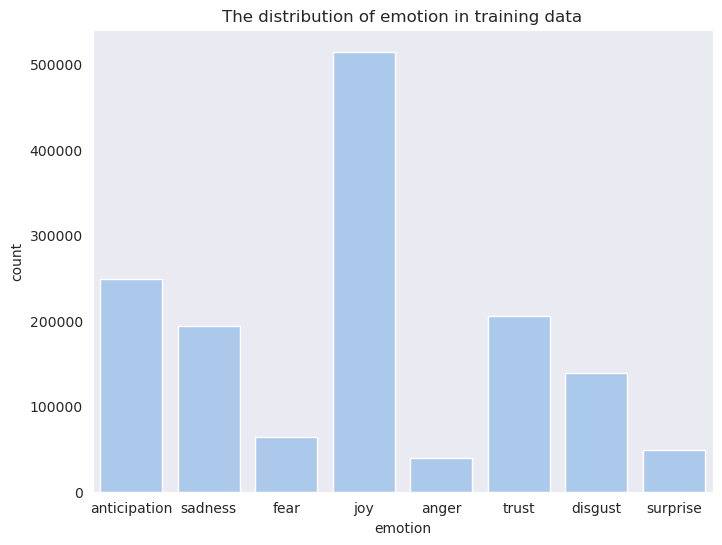

In [18]:
# 1. Plot the distribution of emotion in training data
plt.figure(figsize=(8, 6))
sns.countplot(data=training_data, x="emotion")
plt.title("The distribution of emotion in training data")

plt.show()

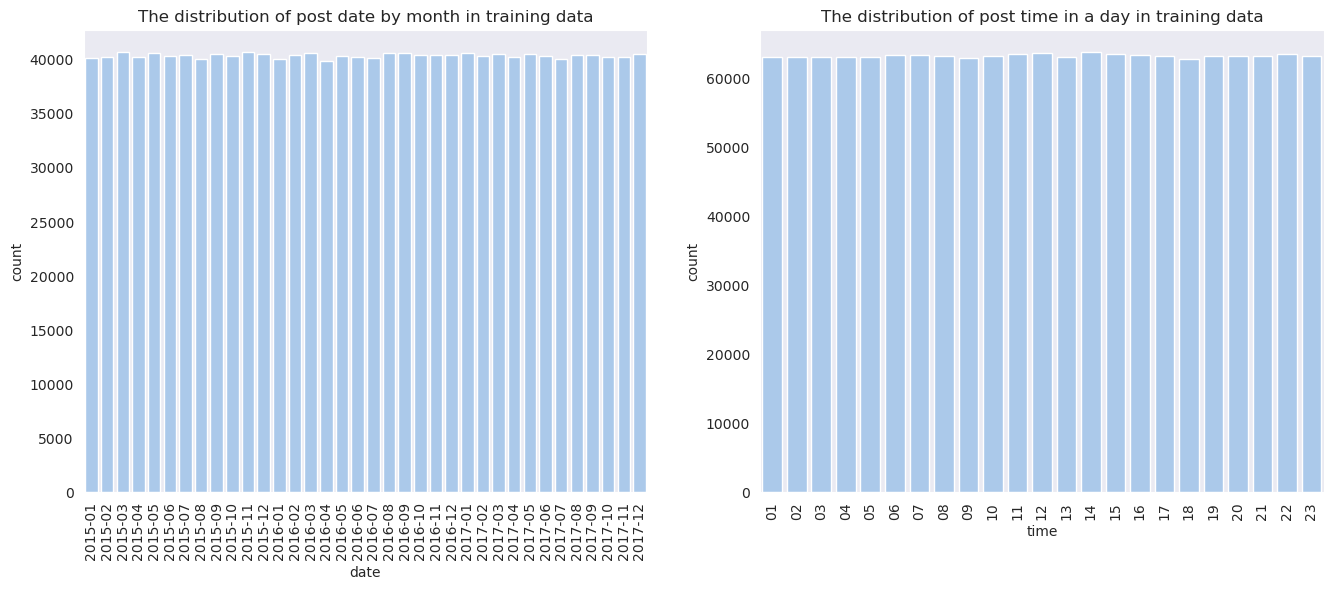

In [19]:
# 2. Plot the distribution of some time features in training data
plt.figure(figsize=(16, 6))

# Plot the distribution of post date by month in training data
training_data["date_for_plot"] = pd.to_datetime(training_data["crawldate"]).dt.strftime(
    "%Y-%m"
)

plt.subplot(1, 2, 1)
sns.countplot(data=training_data.sort_values(by="date_for_plot"), x="date_for_plot")
plt.xticks(rotation=90)
plt.xlabel("date")
plt.title("The distribution of post date by month in training data")

# Plot the distribution of post time in a day in training data
training_data["time_for_plot"] = pd.to_datetime(training_data["crawldate"]).dt.strftime(
    "%H"
)

plt.subplot(1, 2, 2)
sns.countplot(data=training_data.sort_values(by="time_for_plot"), x="time_for_plot")
plt.xticks(rotation=90)
plt.xlabel("time")
plt.title("The distribution of post time in a day in training data")

plt.show()

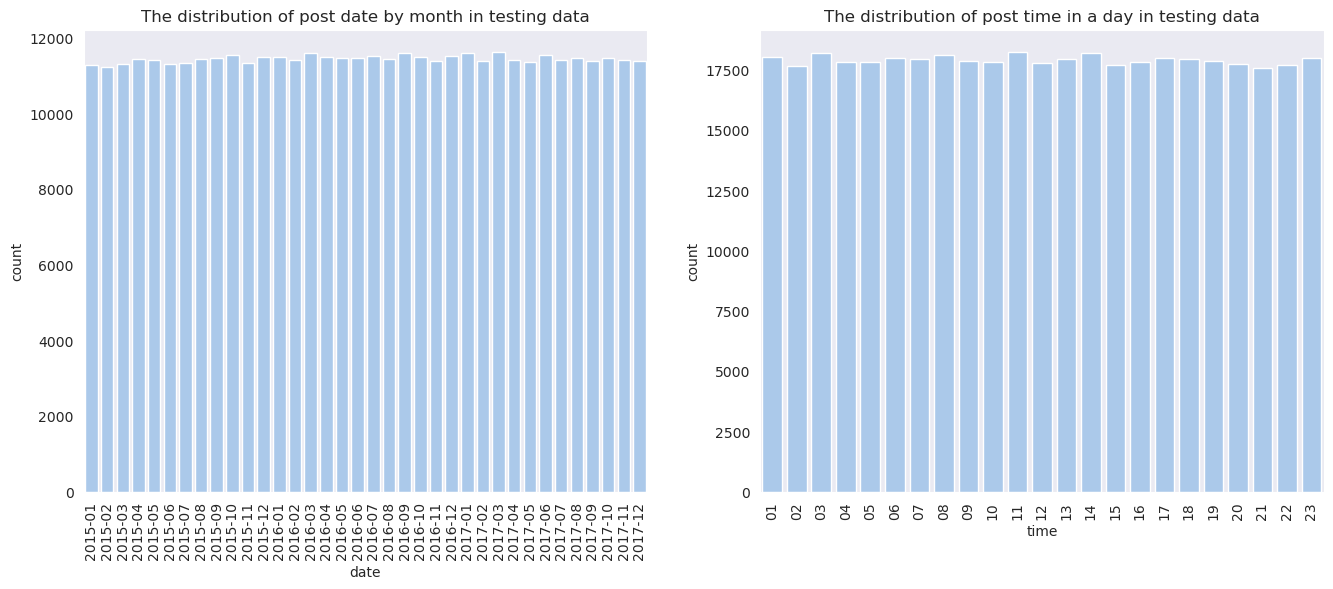

In [20]:
# 3. Plot the distribution of some time features in testing data, to see whether the distribution is similar to training data
plt.figure(figsize=(16, 6))

# Plot the distribution of post date by month in testing data
testing_data["date_for_plot"] = pd.to_datetime(testing_data["crawldate"]).dt.strftime(
    "%Y-%m"
)

plt.subplot(1, 2, 1)
sns.countplot(data=testing_data.sort_values(by="date_for_plot"), x="date_for_plot")
plt.xticks(rotation=90)
plt.xlabel("date")
plt.title("The distribution of post date by month in testing data")

# Plot the distribution of post time in a day in testing data
testing_data["time_for_plot"] = pd.to_datetime(testing_data["crawldate"]).dt.strftime(
    "%H"
)

plt.subplot(1, 2, 2)
sns.countplot(data=testing_data.sort_values(by="time_for_plot"), x="time_for_plot")
plt.xticks(rotation=90)
plt.xlabel("time")
plt.title("The distribution of post time in a day in testing data")

plt.show()

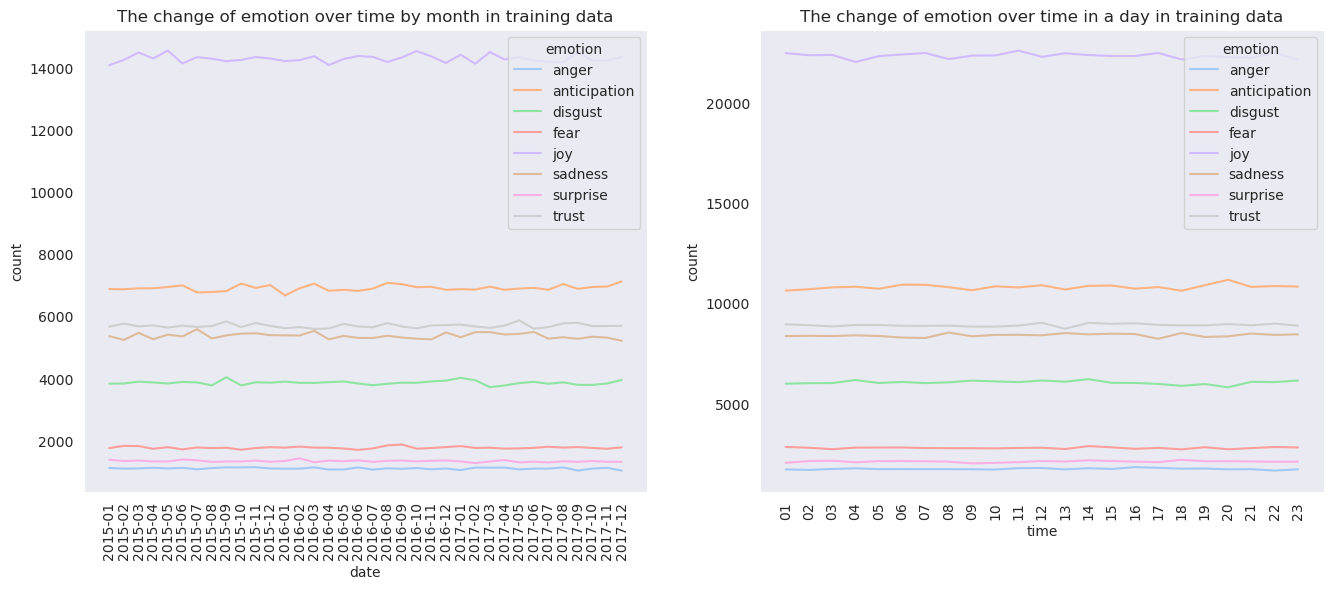

In [21]:
plt.figure(figsize=(16, 6))

# 4. Plot the distribution of emotion over time by month in training data
plt.subplot(1, 2, 1)
sns.lineplot(
    data=training_data.groupby(["date_for_plot", "emotion"]).size().unstack(),
    dashes=False,
)
plt.xticks(rotation=90)
plt.xlabel("date")
plt.ylabel("count")
plt.title("The change of emotion over time by month in training data")

# 5. Plot the distribution of emotion over time in a day in training data
plt.subplot(1, 2, 2)
sns.lineplot(
    data=training_data.groupby(["time_for_plot", "emotion"]).size().unstack(),
    dashes=False,
)
plt.xticks(rotation=90)
plt.xlabel("time")
plt.ylabel("count")
plt.title("The change of emotion over time in a day in training data")

plt.show()

## 2.7 Visualization II (Emotion vs. Score)

Except the time feature, I also want to know if the score can give me another information about the data.
So I plot:

1. The distribution of score.
2. The distribution of score for each emotion. (only training data)

And I find out that:

1. In this dataset, the distribution of the score is almost uniform.
2. In this dataset, the score is independent with emotion.


In [22]:
# Check the range of score to help me decide the number of bins in the histogram
print(
    "The range of score: "
    f"[{training_data['score'].min()}, {training_data['score'].max()}]"
)

The range of score: [1, 1024]


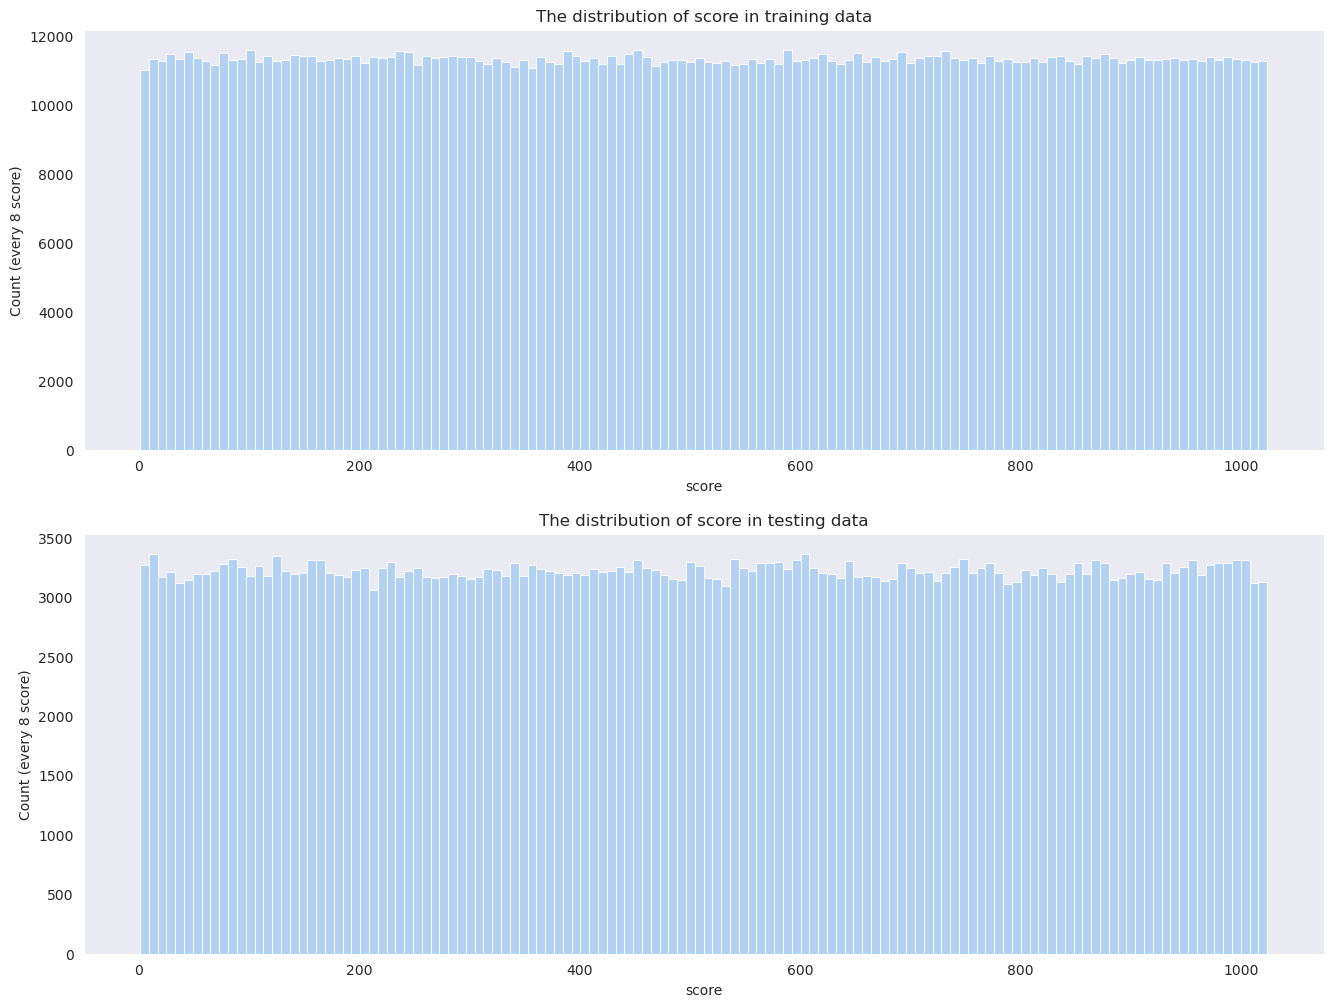

In [23]:
# 1. Plot the distribution of score
plt.figure(figsize=(16, 12))

# Plot for training data
plt.subplot(2, 1, 1)
sns.histplot(data=training_data, x="score", bins=128)
plt.ylabel("Count (every 8 score)")
plt.title("The distribution of score in training data")


# Plot for testing data
plt.subplot(2, 1, 2)
sns.histplot(data=testing_data, x="score", bins=128)
plt.ylabel("Count (every 8 score)")
plt.title("The distribution of score in testing data")

plt.show()

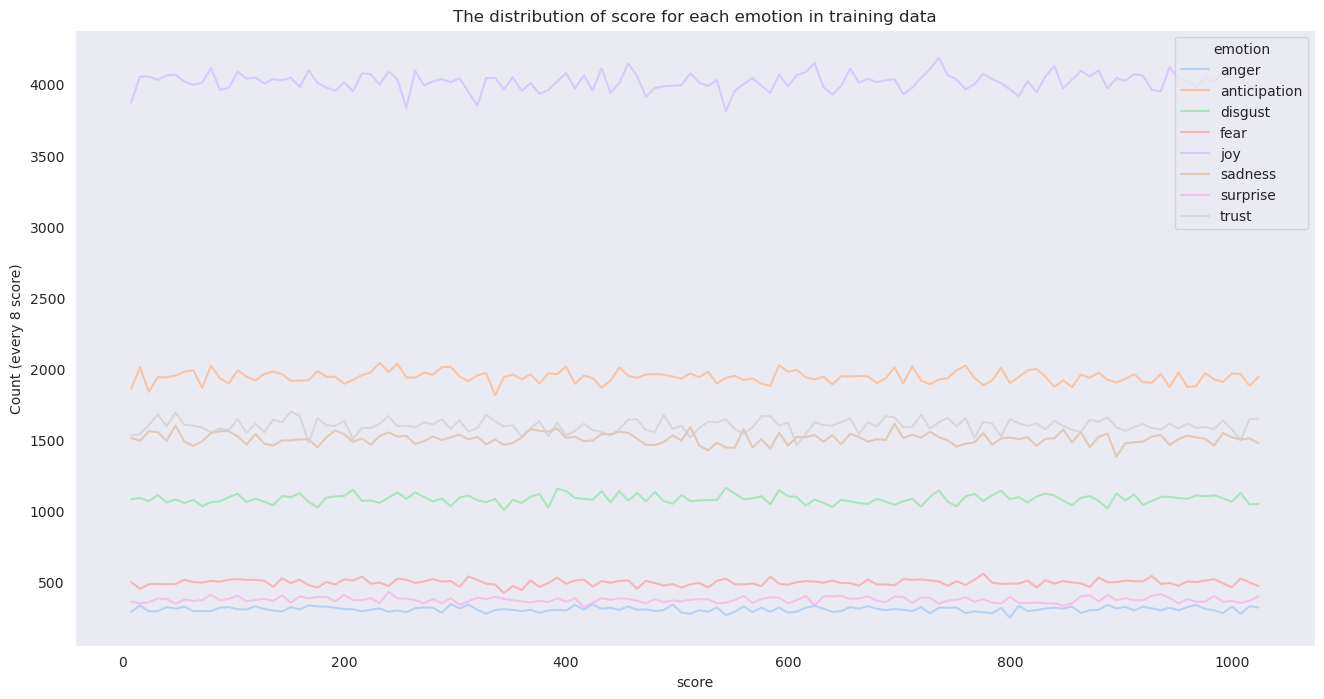

In [24]:
# 2. Plot the distribution of score for each emotion
training_data["score_for_plot"] = training_data["score"].apply(
    lambda x: (x + 7) // 8 * 8
)  # 8 is the bin size, result is the bin number. e.g. 1~8 -> 1, 1017~1024 -> 128

plt.figure(figsize=(16, 8))
sns.lineplot(
    data=training_data.groupby(["score_for_plot", "emotion"]).size().unstack(),
    dashes=False,
    alpha=0.7,
)
plt.xlabel("score")
plt.ylabel("Count (every 8 score)")
plt.title("The distribution of score for each emotion in training data")

plt.show()

## 2.8 Save the Dataset


In [ ]:
# Remove the redundant columns that is not useful for me to do classification
print("Since the time don't have much influence on the emotion, I decide to remove it.")
training_data.drop(columns=["crawldate", "score"], inplace=True)
testing_data.drop(columns=["crawldate", "score"], inplace=True)

# Remove the redundant columns that only used for plotting
training_data.drop(
    columns=["date_for_plot", "time_for_plot", "score_for_plot"], inplace=True
)
testing_data.drop(columns=["date_for_plot", "time_for_plot"], inplace=True)

Since the time don't have much influence on the emotion, I decide to remove it.


In [26]:
print("Training data overview:")
display(training_data.head())

print("Testing data overview:")
display(testing_data.head())

Training data overview:


,tweet_id,text,hashtags,emotion,label
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",[Snapchat],anticipation,1
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...","[freepress, TrumpLegacy, CNN]",sadness,5
2,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,NaN,fear,3
3,0x1d755c,@RISKshow @TheKevinAllison Thx for the BEST TI...,"[authentic, LaughOutLoud]",joy,4
4,0x2c91a8,Still waiting on those supplies Liscus. <LH>,NaN,anticipation,1


Testing data overview:


,tweet_id,text,hashtags
0,0x28b412,"Confident of your obedience, I write to you, k...",[bibleverse]
1,0x2de201,"""Trust is not the same as faith. A friend is s...",NaN
2,0x218443,When do you have enough ? When are you satisfi...,"[materialism, money, possessions]"
3,0x2939d5,"God woke you up, now chase the day #GodsPlan #...","[GodsPlan, GodsWork]"
4,0x26289a,"In these tough times, who do YOU turn to as yo...",NaN


In [27]:
training_data.to_csv(os.path.join(DATA_FILE_PATH, "training_data.csv"), index=False)
testing_data.to_csv(os.path.join(DATA_FILE_PATH, "testing_data.csv"), index=False)

# 3. Data Preprocessing

1. Text Segmentation: I split the word when texts encounter blank space, so I can do preprocess more easily.
2. Replace E-mails (ID + at sign + address), mentions (at sign + user ID)
3. Replace URLs
4. Replace speical symbols
5. Remove the empty texts


## 3.1 Load Datasets


In [2]:
training_data = pd.read_csv(
    os.path.join(DATA_FILE_PATH, "training_data.csv"), lineterminator="\n"
)
testing_data = pd.read_csv(
    os.path.join(DATA_FILE_PATH, "testing_data.csv"), lineterminator="\n"
)

In [3]:
# Text segmentation for doing preprocessing
training_data["text"] = training_data["text"].str.split()
testing_data["text"] = testing_data["text"].str.split()

## 3.2 Replace @ Symbol

1. Replace E-mails with <EML\>: I want to help the model recognize the position has an E-mail originally, so it won't 'confuse'.
2. Remove mentions: Reason is similar as the replacement of E-mails.


In [4]:
# Replace E-mail with <eml>
training_data["text"] = training_data["text"].apply(
    lambda x: [
        re.sub(r"\b[\w.%+-]+@[\w.-]+\.[A-Z|a-z]{2,}\b", "<eml>", word) for word in x
    ]
)
testing_data["text"] = testing_data["text"].apply(
    lambda x: [
        re.sub(r"\b[\w.%+-]+@[\w.-]+\.[A-Z|a-z]{2,}\b", "<eml>", word) for word in x
    ]
)

# Replace mention with <usr>
training_data["text"] = training_data["text"].apply(
    lambda x: [re.sub(r"@\w+", "<usr>", word) for word in x]
)
testing_data["text"] = testing_data["text"].apply(
    lambda x: [re.sub(r"@\w+", "<usr>", word) for word in x]
)

## 3.3 Replace URLs

I found out there are about two types URLs in the dataset：

1. Start with `http://`, `https://`, `www.`, `://`, `//`
2. Containing `.com`
   And I decide to replace all of them into <url\> to avoid noises, but let the model know there was an URL at same time.


In [5]:
# Remove URLs
# Remove the URLs that start with "http://"", "https://", "www.", "://", "//"
training_data["text"] = training_data["text"].apply(
    lambda x: [
        re.sub(
            r"(?:https?://|www\.|:?//|:?//)[\w-]+[\.|/|\?][\w./?=&%#-]+", "<url>", word
        )
        for word in x
    ]
)
testing_data["text"] = testing_data["text"].apply(
    lambda x: [
        re.sub(
            r"(?:https?://|www\.|:?//|:?//)[\w-]+[\.|/|\?][\w./?=&%#-]+", "<url>", word
        )
        for word in x
    ]
)

# Remove the URLs like "forbes.com"
training_data["text"] = training_data["text"].apply(
    lambda x: [re.sub(r"[\w-]+\.com(?:\b|/)", "<url>", word) for word in x]
)
testing_data["text"] = testing_data["text"].apply(
    lambda x: [re.sub(r"[\w-]+\.com(?:\b|/)", "<url>", word) for word in x]
)

## 3.4 Replace Special Symbols

1. I oberseve that <LH\> seems to be some masked words, so I decide to replace it with <mask\> (the mask token of RoBERTa)
2. Replace remaning "@" with "at": I want to make the model know more about what this sign means. (After the competition, I think this action may be redundent, I should do analyze first so it will be more reasonable.
3. Remove number sign: I want to drop the number sign, so the model won't be affected by it when seeing a hashtag.


In [6]:
# Replace <LH> with <mask>
training_data["text"] = training_data["text"].apply(
    lambda x: [re.sub(r"<LH>", "<mask>", word) for word in x]
)
testing_data["text"] = testing_data["text"].apply(
    lambda x: [re.sub(r"<LH>", "<mask>", word) for word in x]
)

# Replace remaning "@" with "at"
training_data["text"] = training_data["text"].apply(
    lambda x: [re.sub(r"@", "at", word) for word in x]
)
testing_data["text"] = testing_data["text"].apply(
    lambda x: [re.sub(r"@", "at", word) for word in x]
)

# Remove number sign
training_data["text"] = training_data["text"].apply(
    lambda x: [re.sub(r"#", "", word) for word in x]
)
testing_data["text"] = testing_data["text"].apply(
    lambda x: [re.sub(r"#", "", word) for word in x]
)

## 3.5 Remove Empty Texts


In [8]:
print(
    "The amount of empty text after removing <url>, <usr>, <eml>, <mask> is: ",
    training_data["text"]
    .apply(lambda x: re.sub(r"<url>|<usr>|<eml>|<mask>", "", "".join(x)) == "")
    .sum(),
)

# Remove the text that is empty after removing <url>, <usr>, <eml>, <mask>
training_data = training_data[
    training_data["text"].apply(
        lambda x: re.sub(r"<url>|<usr>|<eml>|<mask>", "", "".join(x)) != ""
    )
].reset_index(drop=True)

The amount of empty text after removing <url>, <usr>, <eml>, <mask> is:  9


# 4. Fine-tuning

During the competition, I utilize two model:

1. BERT (bert-large-uncased): The reason I choose uncased model is that I think the sentiment classification task on social media has little need of cased things. Since they rarely contains proper nouns in the texts.
2. RoBERTa (roberta-base): The reason I choose the model is that I have known it has better performance on sentiment classification task and it utilize more training data to have a better understanding of words compares to BERT.


## 4.1 Build up Dataset for Training

1. Concatenate each list of the segmented text to single sentence for tokenization.
2. Use tokenizer of RoBERTa to tokenize the texts. (Since I have additional special tokens, so I should add them into the vocabulary of the tokenizer.)
3. Define the data structure "MyDataset".
4. Define the collate function to do some basic preprocessing for training RoBERTa.
5. Build up the DataLoader for training dataset and testing dataset.


In [9]:
# Concatenate the segmented texts to sentences for tokenizer
training_data["text"] = training_data["text"].apply(lambda x: " ".join(x))
testing_data["text"] = testing_data["text"].apply(lambda x: " ".join(x))

In [ ]:
# Define the tokenizer
tokenizer = T.AutoTokenizer.from_pretrained(MODEL_NAME, cache_dir="cache")
special_tokens = {
    "additional_special_tokens": ["<eml>", "<usr>", "<url>"],
}
tokenizer.add_special_tokens(special_tokens)


class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # for training data
        if len(self.data.iloc[0]) == 5:
            return self.data["text"][index], self.data["label"][index]
        # for testing data, the reason I output the tweet_id first is that I can build collate_fn easier (to distinguish the batch is training or testing) 
        else:
            return self.data["tweet_id"][index], self.data["text"][index]


def collate_fn(batch):
    # for training data
    if type(batch[0][1]) == np.int64:
        texts = [item[0] for item in batch]
        labels = [item[1] for item in batch]
    # for testing data
    else:
        texts = [item[1] for item in batch]
        tweet_ids = [item[0] for item in batch]
    # Tokenize the text
    tokenized_texts = tokenizer(
        [text for text in texts],
        padding=True,
        truncation=True,
        return_tensors="pt",
    )

    # for training data
    if type(batch[0][1]) == np.int64:
        return tokenized_texts, torch.LongTensor(labels)
    # for testing
    else:
        return tokenized_texts, tweet_ids


# Defien the dataloaders
dl_train = DataLoader(
    MyDataset(training_data), batch_size=batch_size, shuffle=True, collate_fn=collate_fn
)

dl_test = DataLoader(
    MyDataset(testing_data), batch_size=batch_size, shuffle=False, collate_fn=collate_fn
)

## 4.2 Define the Model

1. Resize the model (let it know the new vocabulary)
2. My model structure is very simple: RoBERTa -> Dropout (dropout rate = 0.2) -> Fully connected layer (aggregate informations + do classification)
3. My loss function is cross entropy, since it's quite fit with classification tasks.
4. My optimizer is AdamW, since it's the most popular optimizer (when we still don't know much about the dataset).


In [11]:
encoding_model = T.AutoModel.from_pretrained(MODEL_NAME, cache_dir="cache")

encoding_model.resize_token_embeddings(len(tokenizer))


class MyModel(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.encoder = encoding_model
        self.nn = torch.nn.Sequential(
            torch.nn.Dropout(drop_out),
            torch.nn.Linear(self.encoder.config.hidden_size, 8),
        )

    def forward(self, **kwargs):
        encoded_inputs = self.encoder(**kwargs)
        logits = self.nn(encoded_inputs["pooler_output"])

        return logits

2024-12-04 17:33:24.392329: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 17:33:24.486598: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 17:33:24.518783: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 17:33:24.526203: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 17:33:24.605351: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
model = MyModel().to(device)
# To use multiple GPUs
model = torch.nn.DataParallel(model)

# Define the loss function and how we do gradient descent
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = torch.nn.CrossEntropyLoss()

## 4.3 Training


In [13]:
for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for batch in tqdm(dl_train):
        input_ids = batch[0]["input_ids"].to(device)
        attention_mask = batch[0]["attention_mask"].to(device)
        label = batch[1].to(device)

        optimizer.zero_grad()
        pred = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(pred, label)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (pred.argmax(1) == label).sum().item()
        train_total += label.size(0)

    train_loss /= len(dl_train)
    train_acc = train_correct / train_total

    print(
        f"[Epoch {epoch + 1}/{epochs}]:"
        f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}"
    )

    torch.save(model, f"models/myModel_ep{epoch + 1}.pth")

100%|██████████| 15123/15123 [59:55<00:00,  4.21it/s] 


[Epoch 1/5]:Train loss: 1.0267, Train acc: 0.6272


100%|██████████| 15123/15123 [59:51<00:00,  4.21it/s] 


[Epoch 2/5]:Train loss: 0.8955, Train acc: 0.6749


100%|██████████| 15123/15123 [59:50<00:00,  4.21it/s] 


[Epoch 3/5]:Train loss: 0.8220, Train acc: 0.7013


100%|██████████| 15123/15123 [59:52<00:00,  4.21it/s] 


[Epoch 4/5]:Train loss: 0.7571, Train acc: 0.7244


100%|██████████| 15123/15123 [59:49<00:00,  4.21it/s] 


[Epoch 5/5]:Train loss: 0.6965, Train acc: 0.7460


## 4.4 Prediction


In [ ]:
# Since my best model is the result of epoch 3 (for RoBERTa), so I load the model of epoch 3
model = torch.load("models/myModel_ep3.pth")

/tmp/ipykernel_2664/3004317410.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("models/myModel_ep2.pth")


In [29]:
id_list = []
emotion_list = []
label_to_emotion = {
    0: "anger",
    1: "anticipation",
    2: "disgust",
    3: "fear",
    4: "joy",
    5: "sadness",
    6: "surprise",
    7: "trust",
}

model.eval()
with torch.no_grad():
    for batch in tqdm(dl_test):
        input_ids = batch[0]["input_ids"].to(device)
        attention_mask = batch[0]["attention_mask"].to(device)
        tweet_ids = batch[1]

        pred = model(input_ids=input_ids, attention_mask=attention_mask)
        pred = pred.argmax(1).cpu().numpy()
        emotion = [label_to_emotion[p] for p in pred]

        id_list += tweet_ids
        emotion_list += emotion

100%|██████████| 4292/4292 [07:15<00:00,  9.86it/s]


In [ ]:
submission = pd.DataFrame({"id": id_list, "emotion": emotion_list})
submission.to_csv(os.path.join(CURRENT_PATH, "results/submission.csv"), index=False)